# Вебинар 5


---

## Комментарии к домашним заданиям

### 1. Общие

ALS
- На вход принимает только *позитивные* взаимодействия
- Прогнозирует **не** вероятность, а некоторые числа
- В ALS нельзя добавить внешние фичи
- ALS не учитывает сезонность / зависимость во времени (но это можно частично поправить - см далее)
- Можно использовать для ранжирования (как - см далее + вебинар 5)

### 2. Что на самом деле оптимизирует ALS

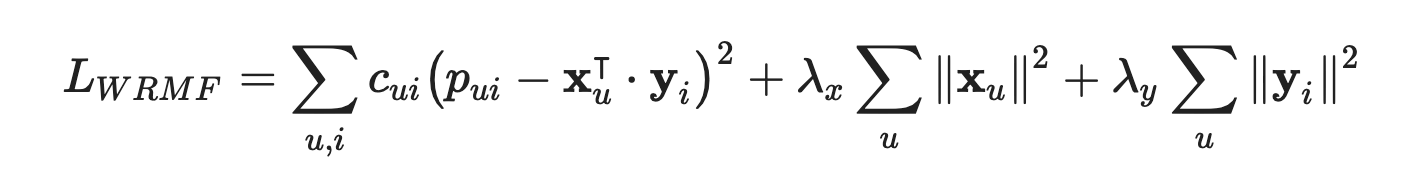

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Что делает ALS**
- Максимизирует скалярное произведение (dot product) между векторами user-item для позитивных interactions, минимизирует для негативных

**Скалярное призведение (dot product) VS косинусная схожесть (cosine similarity)**

$$dot(a, b) = a * b$$  
  
$$cos(a, b) = \frac{a * b}{||a||*||b||} = \frac{dot(a, b)}{||a||*||b||}$$

### 3. Как учитывать изменение вкусов потребителей во времени / изменение популярности товара во времени

- Летом юзеры любят мороженое, а зимой - нет
- Многие фильмы популярны во время проката в кино, затем их популярность снижается

*Что делать?*  
Ограничить давность взаимодейстий.  
Давать последним взаимодействиям больший вес:  

$$value_w = \sum_i value_i * \frac{1}{1 + \exp^{ \alpha*t}}$$

### 4. Как использовать для ранжирования (Краткое введение. Подробности - на предыдущем вебинаре)

**Вариант 1.**  
*As is* - ранжировать по output ALS

**Вариант 2.**
*Та же модель, другой лосс - BPR*

BPR - Bayesian Personalized Ranking loss
1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p_{ui}$, $p_{uj}$ --> $p_{ui} - p_{uj}$
4. loss = $\sigma(p_{ui} - p_{uj})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

In [1]:
from implicit.bpr import BayesianPersonalizedRanking

Синтаксис такой же как у AlternatingLeastSquares. ML модель такая же, лосс - BPR

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items

In [4]:
data = pd.read_csv('./raw_data/transaction_data.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1.0,1004906.0,1.0,1.39,364.0,-0.6,1631.0,1.0,0.0,0.0
1,2375,26984851472,1.0,1033142.0,1.0,0.82,364.0,0.0,1631.0,1.0,0.0,0.0


In [5]:
item_features = pd.read_csv('./raw_data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[836548.0, 856942.0, 877391.0, 933913.0, 94842..."
1,2,"[826784.0, 827176.0, 830127.0, 834826.0, 86814..."


In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [11]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train, item_features, take_n_popular=5000)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

TypeError: prefilter_items() got an unexpected keyword argument 'take_n_popular'

In [9]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

user_item_matrix.head(3)

item_id,25671.0,26081.0,26093.0,26190.0,26355.0,26426.0,26540.0,26601.0,26636.0,26691.0,...,16809431.0,16809471.0,16809581.0,16809649.0,16809685.0,16828772.0,16830135.0,16830440.0,16830507.0,17105257.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [ ]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [ ]:
%%time

model = AlternatingLeastSquares(factors=20, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

In [ ]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=True)]
    return res

In [ ]:
%%time
    
result['bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

In [ ]:
result.head(2)

----

# Альтернативные способы предсказаний

### Кейс 1. Продажи товаров собственной торговой марки (СТМ)

У многих ритейлеров есть товары СТМ:
    - Азбука Вкуса - Просто Азбука
    - Ашан - Каждый день
    - ВкусВилл - Избёнка
    - ...
    
Как правило, у них маржинальность (~прибыль) > обычные товары.   
Как сделать так, чтобы юзеры переключились на товары СТМ? - *рекоммендации!*

*Нужно заменить те товары, которые пользователь уже покупает, на товары СТМ*

In [ ]:
item_features.head(2)

In [ ]:
item_features = item_features[item_features['item_id'].isin(itemid_to_id.keys())]
item_features[item_features['brand'] == 'Private'].item_id.nunique()

In [ ]:
own_items = item_features[item_features['brand'] == 'Private'].\
    groupby('department')['item_id'].nunique().\
    sort_values(ascending=False)
own_items

In [ ]:
categories_with_own_items = own_items.index.tolist()

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42, n_iter=300, n_iter_without_progress=20)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [ ]:
model.item_factors.shape

In [ ]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [ ]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne')
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne['item_id'] = list(itemid_to_id.keys())
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

In [ ]:
item_emb_tsne_reduced = item_emb_tsne[item_emb_tsne['category'] != 'GROCERY']

In [ ]:
display_components_in_2D_space(item_emb_tsne_reduced, labels='category')

Нарисуем все товары в катгеориях, где есть СТМ

In [ ]:
display_components_in_2D_space(item_emb_tsne_reduced[item_emb_tsne_reduced['category'].isin(categories_with_own_items)], 
                               labels='category')

In [ ]:
similar_items = model.similar_items(itemid_to_id[1004906], N=50)
similar_items = [id_to_itemid[sim[0]] for sim in similar_items]
similar_items.append(1004906)

In [ ]:
item_emb_tsne[item_emb_tsne['item_id'] == 1004906]

In [ ]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['item_id'].isin(similar_items)], 
                               labels='category')

Берем топ-5 популярных покупок юзера --> находим по 1 наиболее близкому товару СТМ для них --> рекомендуем

In [ ]:
# your_code

popularity = data_train.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
popularity.sort_values('quantity', ascending=False, inplace=True)

#popularity = popularity[popularity['item_id'] != 999999]

popularity = popularity.groupby('user_id').head(5)

popularity.sort_values('user_id', ascending=False, inplace=True)
popularity.head(2)

In [ ]:
%%time

def get_rec(model, x):
    recs = model.similar_items(itemid_to_id[x], N=2)
    top_rec = recs[1][0]
    return id_to_itemid[top_rec]
    

popularity['similar_recommendation'] = popularity['item_id'].apply(lambda x: get_rec(model, x))
popularity.head(3)

In [ ]:
recommendation_similar_items = popularity.groupby('user_id')['similar_recommendation'].unique().reset_index()
recommendation_similar_items.columns=['user_id', 'similar_recommendation']
recommendation_similar_items.head(2)

In [ ]:
result = result.merge(recommendation_similar_items, on='user_id', how='left')
result.head(2)

In [ ]:
%load_ext autoreload

### Кейс 2. Вашим друзьям нравится / Похожим пользователям нравится / ...

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [ ]:
userid_to_id[10]

In [ ]:
model.similar_users(userid_to_id[10], N=6)

In [ ]:
def get_recommendations(user, model, sparse_user_item, N=5):
    """Рекомендуем топ-N товаров"""
    
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=True)]
    return res

In [ ]:
%%time

own = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

own.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)


In [ ]:
get_recommendations(user=1, model=own, N=1)

-----

# Production

Вы можете дополнить функцию prefilter_items: 
- Убрать товары, которые не продавались за последние 12 месяцев
- Убервть не интересные для рекоммендаций категории (department)

и тд

Однако пока это не необходимо

In [ ]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    # Уберем слишком дорогие товарыs
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

In [ ]:
def get_recommendations(user, model, sparse_user_item, N=5):
    """Рекомендуем топ-N товаров"""
    
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=True)]
    return res

In [ ]:
def get_similar_items_recommendation(user, model, N=5):
    """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
    
    # your_code
    
    return res

In [ ]:
def get_similar_users_recommendation(user, model, N=5):
    """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""
    
    # your_code
    
    return res

----